In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import kerastuner as kt
from sklearn.model_selection import train_test_split

In [ ]:
#input with all maxima
df_spectra_all=pd.read_csv("spectrum_energy_input_numberOfPeaks.csv",index_col=[0])
x_data_string=df_spectra_all["all_maxima"].values

max_nr_of_max=df_spectra_all['no_of_max'].max()
len_array=len(df_spectra_all["all_maxima"].values)

print(max_nr_of_max,len_array)
x_data_padded=np.zeros((len_array,max_nr_of_max))

for i,x_string in enumerate(x_data_string):
    x_string=x_string.replace('\n','').replace('[','').replace(']','')
    x_split= x_string.split(' ')
    j=0
    for x in (x_split):
        if(x!=''):
            #print(x)
            x_data_padded[i,j]=float(x)
            j=j+1
    #print("cut")

y_data=df_spectra_all[["k6a1","k6a2","k11","k12","k9a1","k9a2"]].to_numpy()


y_data=y_data-0.5
y_data=y_data*4


data_train, data_test, labels_train, labels_test = train_test_split(x_data_padded, y_data, test_size=0.20, random_state=42)
   
print(data_train.shape)

def transform_data(df,index):
    data=df[index].to_numpy()
    new_data=np.zeros((len(data),max(data)+1))    
    for i in range(len(data)):
        new_data[i,data[i]]=1
    return new_data
    
df_spectra=pd.read_csv("spectrum_energy_input_numberOfPeaks.csv",index_col=[0])
df_new=df_spectra.loc[df_spectra["k11"] == 0]


x_data=transform_data(df_new,"no_of_max")
print(x_data[0:2])



y_data=df_spectra[["k6a1","k6a2","k11","k12","k9a1","k9a2"]].to_numpy()


y_data=y_data-0.5
y_data=y_data*4
print(y_data[0:10])


data_train, data_test, labels_train, labels_test = train_test_split(x_data, y_data, test_size=0.20, random_state=42)

print(data_train.shape)
print(labels_train.shape)

#df_training = df_spectra.sample(frac=0.8,random_state=10)
#df_testing=df_spectra.drop(df_training.index)
#df_spectra.head()

In [ ]:
feature_columns_A = []

no_of_max = tf.feature_column.numeric_column("all_maxima")
my_feature_layer_A = tf.keras.layers.DenseFeatures(no_of_max)

#transform data


In [ ]:

def plot_the_loss_curve(epochs, mse,val_mse):
    """Plot a curve of loss vs. epoch."""

    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Mean Squared Error")

    plt.plot(epochs, mse, label="Loss")
    plt.plot(epochs, val_mse, label="Val Loss")

    plt.legend()
    #plt.ylim([0, 15])
    plt.show()  

def create_model(my_learning_rate, my_feature_layer):
    model = tf.keras.models.Sequential()
    # Add the layer containing the feature columns to the model.
    # Define the first hidden layer with 10 nodes.   
   # model.add(my_feature_layer_A)
    #layers=[5,10]
    layers=[600,600,600,600]
    for layer in layers:
        model.add(tf.keras.layers.Dense(units = layer, activation = 'sigmoid',kernel_regularizer=tf.keras.regularizers.l1(0.0)))
    # Define the output layer.
    model.add(tf.keras.layers.Dense(units=6,  
                                    name='Output',activation="sigmoid"))#,kernel_regularizer=tf.keras.regularizers.l2(0.04)))                              
  
    model.compile(optimizer=tf.keras.optimizers.SGD(lr=my_learning_rate,momentum=0.1),
                loss="mean_squared_error",
                metrics=[tf.keras.metrics.MeanSquaredError()])

    return model



def train_model(model, x,y, epochs, label_name,
                batch_size=None):

    #features = {name:np.array(value) for name, value in dataset.items()}
    #label=dataset[label_name].to_numpy()
    history = model.fit(x=x, y=y, batch_size=batch_size,
                      epochs=epochs, shuffle=True, verbose=1,validation_split=0.2) 
    
    epochs = history.epoch
  
    df_hist = pd.DataFrame(history.history)
    #hist.head()
    #mse = hist["mean_squared_error"]
    mae = df_hist["mean_squared_error"].to_numpy()
    val_mae = df_hist["val_mean_squared_error"].to_numpy()
    return epochs,mae,val_mae

In [ ]:
# The following variables are the hyperparameters.
#data_train, data_test, labels_train, labels_test
learning_rate = 1e-1
epochs = 500
batch_size = 400

label_name = ["k6a1","k6a2","k11","k12","k9a1","k9a2"]

my_model = create_model(learning_rate, my_feature_layer_A)

epochs, mse,val_mse = train_model(my_model, data_train,labels_train, epochs, 
                          label_name, batch_size)


In [ ]:
#features = {name:np.array(value) for name, value in df_test.items()}
#label=df_test[label_name].to_numpy()
#data_train, data_test, labels_train, labels_test
plot_the_loss_curve(epochs, mse,val_mse)
evaluation=my_model.evaluate(x = data_test, y = labels_test, batch_size=batch_size)
predicted = my_model.predict(data_test)
print(evaluation)



df_test=pd.DataFrame(labels_test,columns=["k6a1_test","k6a2_test","k11_test","k12_test","k9a1_test","k9a2_test"])
df_predict=pd.DataFrame(predicted,columns=["k6a1_hat","k6a2_hat","k11_hat","k12_hat","k9a1_hat","k9a2_hat"])
pd.concat([df_test,df_predict], axis=1).head()

In [ ]:
print(data_test[0:5])
print(labels_test[0:5])


In [118]:
#new try with 2d Data:

import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import kerastuner as kt
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical

def get_array_from_strings(data_string, padded_array):
    use_paddad_array=padded_array.copy()
    for i,x_string in enumerate(data_string):
        x_string=x_string.replace('\n','').replace('[','').replace(']','')
        x_split= x_string.split(' ')
        j=0
        for x in (x_split):
            if(x!=''):
                #print(x)
                use_paddad_array[i,j]=float(x)
                j=j+1

    return use_paddad_array

In [265]:
#input with all maxima
df_spectra_all=pd.read_csv("spectrum_energy_input_numberOfPeaks_with_intensity.csv",index_col=[0])
x_Energy_string=df_spectra_all["all_maxima"].values
x_Intensity_string=df_spectra_all["Intensity"].values



max_nr_of_max=df_spectra_all['no_of_max'].max()
len_array=len(df_spectra_all["all_maxima"].values)

#print(max_nr_of_max,len_array)
x_data_padded=np.zeros((len_array,max_nr_of_max))


x_energy_padded=get_array_from_strings(x_Energy_string,x_data_padded)
x_Intensity_padded=get_array_from_strings(x_Intensity_string,x_data_padded)

#print(x_data_padded[:5])    
#print(x_energy_padded[:5])    
#print(x_Intensity_padded[:5])    

#make 2d Array from Energy and Intensity
x_data_2d =np.zeros((len(x_energy_padded),len(x_energy_padded[0]),2))
for i in range(len(x_energy_padded)):
    for j in range(len(x_energy_padded[i])):
        x_data_2d[i,j,0]=x_energy_padded[i,j]
        x_data_2d[i,j,1]=x_Intensity_padded[i,j]

#print(x_data_2d[:5]) 

#convert y_data into 2d array where -1=[1,0] 0=[0,0] 1=[0,1]
y_data=df_spectra_all[["k6a1","k6a2","k11","k12","k9a1","k9a2"]].to_numpy()
y_data=y_data-0.5
y_data=y_data*4
#y_data=y_data+2
y_data_2d =np.zeros((len(y_data),len(y_data[0]),2))
#print(y_data_2d.shape)
for i in range(len(y_data)):
    for j in range(len(y_data[i])):
        if(y_data[i,j]==-1):
            y_data_2d[i,j,0]=1
        elif(y_data[i,j]==1):
            y_data_2d[i,j,1]=1
            
#print(y_data[:5])
#print(y_data_2d[:5])
#this is with 2d label
data_train, data_test, labels_train, labels_test = train_test_split(x_data_2d, y_data_2d, test_size=0.20, random_state=42)

#y_data_cat=to_categorical(y_data)
#print(y_data_cat.shape)
y_data_2d=y_data_2d.reshape(y_data_2d.shape[0],y_data_2d.shape[2]*y_data_2d.shape[1])
#print(y_data_cat.shape)

#this is with 1d label
#data_train, data_test, labels_train, labels_test = train_test_split(x_data_2d, y_data_cat, test_size=0.20, random_state=43)




#maybe reshape data into [nr,x,y,channel=1?]   
print(data_train.shape)
print(labels_train.shape)

(583, 22, 2)
(583, 6, 2)


In [266]:

def plot_the_loss_curve(epochs, mse,val_mse):
    """Plot a curve of loss vs. epoch."""

    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Mean Squared Error")

    plt.plot(epochs, mse, label="Loss")
    plt.plot(epochs, val_mse, label="Val Loss")

    plt.legend()
    #plt.ylim([0, 15])
    plt.show()  

def create_2d_model(my_learning_rate, input_shape):
    model = tf.keras.models.Sequential()
    # Add the layer containing the feature columns to the model.
    # Define the first hidden layer with 10 nodes.   
    
    model.add(tf.keras.layers.Conv1D(64, 4, activation='relu',input_shape=input_shape))
    model.add(tf.keras.layers.Conv1D(128, 4, activation='relu'))
   # model.add(tf.keras.layers.MaxPooling1D(2,2))

    model.add(tf.keras.layers.Conv1D(256, 4, activation='relu'))
    #model.add(tf.keras.layers.MaxPooling1D(128))

    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(units = 512, activation = 'relu',kernel_regularizer=tf.keras.regularizers.l1(0)))
   # model.add(tf.keras.layers.Dropout(0.5))
   # model.add(tf.keras.layers.Dense(units = 6, activation = 'relu',kernel_regularizer=tf.keras.regularizers.l1(0)))

    model.add(tf.keras.layers.Dense(units = 12, activation = 'softmax',kernel_regularizer=tf.keras.regularizers.l1(0.01)))
    #model.add(tf.keras.layers.Flatten())

    
    
    
    model.compile(optimizer=tf.keras.optimizers.SGD(lr=my_learning_rate,momentum=0.01),
                loss="mean_squared_error",
                metrics=[tf.keras.metrics.MeanSquaredError()])

    return model



def train_model(model, x,y, epochs,
                batch_size=None):

    #features = {name:np.array(value) for name, value in dataset.items()}
    #label=dataset[label_name].to_numpy()
    history = model.fit(x=x, y=y, batch_size=batch_size,
                      epochs=epochs, shuffle=True, verbose=1,validation_split=0.1) 
    
    epochs = history.epoch
  
    df_hist = pd.DataFrame(history.history)
    #hist.head()
    #mse = hist["mean_squared_error"]
    mae = df_hist["mean_squared_error"].to_numpy()
    val_mae = df_hist["val_mean_squared_error"].to_numpy()
    return epochs,mae,val_mae

In [267]:
#data_train,data_test,labels_train,labels_test
input_shape=(data_train.shape[1:3])
print(input_shape)



(22, 2)


In [268]:
two_d_model=create_2d_model(0.01,(22,2))
print(labels_train[:5])

[[[0. 0.]
  [1. 0.]
  [1. 0.]
  [1. 0.]
  [0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]
  [1. 0.]
  [0. 0.]
  [1. 0.]
  [0. 1.]]

 [[0. 1.]
  [0. 1.]
  [0. 0.]
  [0. 1.]
  [0. 1.]
  [0. 1.]]

 [[0. 0.]
  [0. 1.]
  [0. 0.]
  [1. 0.]
  [0. 1.]
  [0. 1.]]

 [[1. 0.]
  [0. 0.]
  [0. 1.]
  [1. 0.]
  [1. 0.]
  [0. 0.]]]


In [269]:
two_d_model.summary()


Model: "sequential_47"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_133 (Conv1D)          (None, 19, 64)            576       
_________________________________________________________________
conv1d_134 (Conv1D)          (None, 16, 128)           32896     
_________________________________________________________________
conv1d_135 (Conv1D)          (None, 13, 256)           131328    
_________________________________________________________________
flatten_35 (Flatten)         (None, 3328)              0         
_________________________________________________________________
dense_99 (Dense)             (None, 512)               1704448   
_________________________________________________________________
dense_100 (Dense)            (None, 12)                6156      
Total params: 1,875,404
Trainable params: 1,875,404
Non-trainable params: 0
___________________________________________

In [271]:
epochs, mse,val_mse =train_model(two_d_model,data_train,labels_train,100)

Epoch 1/100


ValueError: in user code:

    H:\Users\Gwydion\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:571 train_function  *
        outputs = self.distribute_strategy.run(
    H:\Users\Gwydion\anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:951 run  **
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    H:\Users\Gwydion\anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2290 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    H:\Users\Gwydion\anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2649 _call_for_each_replica
        return fn(*args, **kwargs)
    H:\Users\Gwydion\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:533 train_step  **
        y, y_pred, sample_weight, regularization_losses=self.losses)
    H:\Users\Gwydion\anaconda3\lib\site-packages\tensorflow\python\keras\engine\compile_utils.py:205 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    H:\Users\Gwydion\anaconda3\lib\site-packages\tensorflow\python\keras\losses.py:143 __call__
        losses = self.call(y_true, y_pred)
    H:\Users\Gwydion\anaconda3\lib\site-packages\tensorflow\python\keras\losses.py:246 call
        return self.fn(y_true, y_pred, **self._fn_kwargs)
    H:\Users\Gwydion\anaconda3\lib\site-packages\tensorflow\python\keras\losses.py:1198 mean_squared_error
        return K.mean(math_ops.squared_difference(y_pred, y_true), axis=-1)
    H:\Users\Gwydion\anaconda3\lib\site-packages\tensorflow\python\ops\gen_math_ops.py:10038 squared_difference
        "SquaredDifference", x=x, y=y, name=name)
    H:\Users\Gwydion\anaconda3\lib\site-packages\tensorflow\python\framework\op_def_library.py:744 _apply_op_helper
        attrs=attr_protos, op_def=op_def)
    H:\Users\Gwydion\anaconda3\lib\site-packages\tensorflow\python\framework\func_graph.py:595 _create_op_internal
        compute_device)
    H:\Users\Gwydion\anaconda3\lib\site-packages\tensorflow\python\framework\ops.py:3327 _create_op_internal
        op_def=op_def)
    H:\Users\Gwydion\anaconda3\lib\site-packages\tensorflow\python\framework\ops.py:1817 __init__
        control_input_ops, op_def)
    H:\Users\Gwydion\anaconda3\lib\site-packages\tensorflow\python\framework\ops.py:1657 _create_c_op
        raise ValueError(str(e))

    ValueError: Dimensions must be equal, but are 12 and 2 for '{{node mean_squared_error/SquaredDifference}} = SquaredDifference[T=DT_FLOAT](sequential_47/dense_100/Softmax, Cast)' with input shapes: [?,12], [?,6,2].


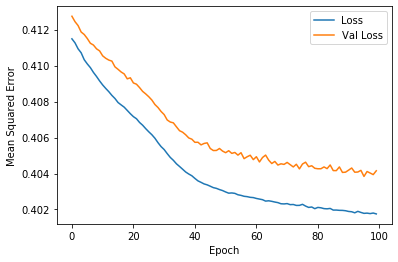

[[[0.03470328 0.03901666]
  [0.03431457 0.2099468 ]
  [0.0348612  0.03866042]
  [0.03472167 0.22833812]
  [0.03544531 0.03807141]
  [0.03616172 0.2357589 ]]

 [[0.00614329 0.00696393]
  [0.00559383 0.30411798]
  [0.00618708 0.00689388]
  [0.00602905 0.2929468 ]
  [0.00629789 0.00676727]
  [0.0063663  0.3456927 ]]

 [[0.00604755 0.00685913]
  [0.00550325 0.30908006]
  [0.00609196 0.00678849]
  [0.00593384 0.29370594]
  [0.00620089 0.00666353]
  [0.00626949 0.34085587]]

 ...

 [[0.04046676 0.04538211]
  [0.04044609 0.1885187 ]
  [0.04063748 0.04498278]
  [0.04063734 0.20746504]
  [0.04127011 0.04436237]
  [0.04214286 0.22368836]]

 [[0.04085221 0.04568024]
  [0.04047033 0.20312402]
  [0.04103537 0.04528886]
  [0.04094205 0.21261394]
  [0.04159788 0.0447351 ]
  [0.04245988 0.20120016]]

 [[0.07886958 0.0861674 ]
  [0.08206756 0.08651379]
  [0.07922275 0.08561568]
  [0.08051212 0.08820982]
  [0.07928785 0.08576187]
  [0.08119325 0.08657828]]]


ValueError: Shape of passed values is (146, 12), indices imply (146, 6)

In [252]:
#features = {name:np.array(value) for name, value in df_test.items()}
#label=df_test[label_name].to_numpy()
#data_train, data_test, labels_train, labels_test
plot_the_loss_curve(epochs, mse,val_mse)
#evaluation=two_d_model.evaluate(x = data_test, y = labels_test)

#print("Hello",data_test[:3])
predicted = two_d_model.predict(data_test)
predicted=predicted.reshape(len(data_test),6,2)
#print(predicted)


#decode labels:
print(predicted)



df_test=pd.DataFrame(labels_test,columns=["k6a1_test","k6a2_test","k11_test","k12_test","k9a1_test","k9a2_test"])
df_predict=pd.DataFrame(predicted,columns=["k6a1_hat","k6a2_hat","k11_hat","k12_hat","k9a1_hat","k9a2_hat"])
pd.concat([df_test,df_predict], axis=1).head(20)